In [41]:
import numpy as np 
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from itertools import combinations

import gensim
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import pickle

##plotting
import matplotlib
import matplotlib.pyplot as plt


In [2]:
pickle_in = open("./spacy_lemv2.pickle","rb")
spacy_text = pickle.load(pickle_in)

In [3]:
df=pd.DataFrame({'body':spacy_text})

In [4]:
def review_words(review_text):
    return(" ".join(review_text))

def combine(df):
    for i in range(len(df)):
        if i%1000==0:
            print(i)
        df[i] = review_words(df[i])  

In [5]:
combine(df.body)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [6]:
df.to_csv('D:/Capstone/dataset/NMF/NMF.csv')

In [ ]:
#vectorize
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=3000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df.body)

In [37]:
terms = tfidf_vectorizer.get_feature_names()

In [22]:
#range of 'k' to test
kmin, kmax = 4, 7
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d" % k )
    # run NMF
    model = NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform(tfidf)
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...


In [18]:
w2v_model = gensim.models.Word2Vec(spacy_text, size=1000, min_count=20, sg=1, workers=4)

In [19]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )
all_terms = w2v_model.wv.vocab

Model has 27976 terms


In [20]:
w2v_model.save('D:/Capstone/dataset/NMF/w2vmodel.bin')

In [33]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [32]:
def calculate_coherence(model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [38]:
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence= %.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.2193
K=05: Coherence=0.2298
K=06: Coherence=0.2237
K=07: Coherence=0.2201


In [42]:
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

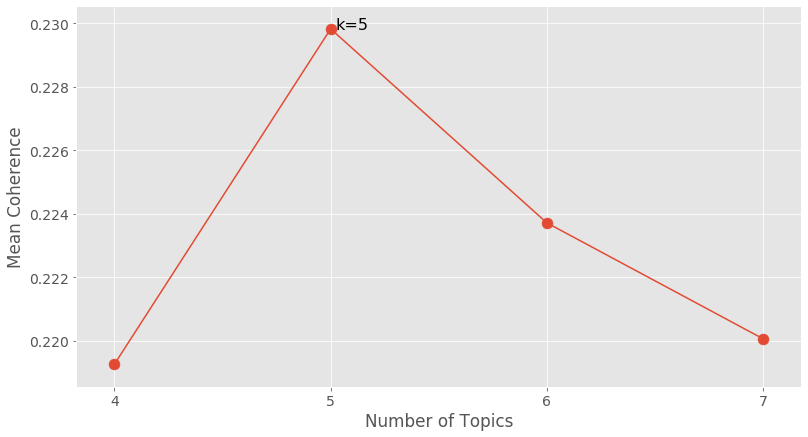

In [43]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)

# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)


plt.show()

In [44]:
k = best_k
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

In [45]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: time, meeting, good, work, think, want, let, week, day, look
Topic 02: intended_recipient, message, corp, confidential, sender, delete, may_contain, receive, reply, strictly_prohibit
Topic 03: agreement, attach, file, draft, comment, letter, review, request, send, change
Topic 04: deal, gas, price, power, volume, contract, energy, change, trade, book
Topic 05: north_america, smith_street, texas, corp, phone_fax, debra_perlingiere, legal_department, sara_shackleton, legal, master


In [ ]:
topic_dict_nmf={topic_index[0]:'social',
                topic_index[1]:'management & confidential',
                topic_index[2]:'daily operations',
                topic_index[3]:'trading',
                topic_index[4]:'legal'}

In [ ]:
break 